<p style="font-size:200%;font-weight:bold">Check Unmatched Keys</p>

- Author: Wenzhi Ding
- Date: 2022-03-23

This notebook is to check the unmatched keys between Compustat and ASSET4/KLD/RepRisk.

In [349]:
import re
import heapq

import pandas as pd
import numpy as np
import jellyfish
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True, nb_workers=6)

DB = "/home/data/"
ROOT = "/home/team_crypto/2022_esg_peer/"

RD = f"{ROOT}02_rdata/"
WD = f"{ROOT}03_wdata/"

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# RepRisk

In [3]:
df = pd.read_parquet(f'{WD}reprisk_compustat.pq')
df.shape
df.sample(3)

(830760, 12)

,RepRisk_ID,date,current_RRI,name,all_ISINs,primary_ISIN,headquarter_country_code,iscu,tic,cusip,conm,_merge
257709,17669,2020-10-31,0,Alco Inc,US0137511020,US0137511020,US,01375110,None,None,None,left_only
342519,22764,2018-04-30,6,Public Service Co of Colorado,US744448CV12 US744448CU39 US744448CT65 US74444...,US744448AH46,US,744448AH,None,None,None,left_only
594968,64413,2013-09-30,10,Biglari Holdings Inc,US08986R1196 US08986R1279 US08986RAA95 US08986...,US08986R1014,US,08986R10,None,None,None,left_only


In [7]:
df['primary_ISIN'].isna().sum()

0

In [4]:
df['_merge'].value_counts()

both          592536
left_only     238224
right_only         0
Name: _merge, dtype: int64

In [38]:
df.loc[df['_merge'] == 'both', 'cusip'].nunique()
df.loc[df['_merge'] == 'both', 'primary_ISIN'].nunique()
df.loc[df['_merge'] == 'left_only', 'primary_ISIN'].nunique()

3527

3527

1418

In [14]:
df.loc[df['_merge'] == 'left_only'].sample()

,RepRisk_ID,date,current_RRI,name,all_ISINs,primary_ISIN,headquarter_country_code,iscu,tic,cusip,conm,_merge
157304,133308,2011-09-30,0,Cornell University,US219207AB38 US219207AA54,US219207AA54,US,219207AA,None,None,None,left_only


In [20]:
df.loc[df['_merge'] == 'both'].sample()

,RepRisk_ID,date,current_RRI,name,all_ISINs,primary_ISIN,headquarter_country_code,iscu,tic,cusip,conm,_merge
46579,10942,2010-08-31,0,Spire Inc (formerly Laclede Group Inc; The),US84857L5075 US84857L6065 US84857LAB71 US84857...,US84857L1017,US,84857L10,SR,84857L101,SPIRE INC,both


In [27]:
df['security_type'] = df['primary_ISIN'].apply(lambda x: x[-4:-2])

In [28]:
df.loc[df['_merge'] == 'both', 'security_type'].value_counts()
df.loc[df['_merge'] == 'left_only', 'security_type'].value_counts()

10    503160
20     45696
30     22848
40      7728
50      4200
60      2688
70      1848
80      1008
86       840
42       336
83       336
84       336
85       336
87       336
88       168
78       168
44       168
13       168
82       168
Name: security_type, dtype: int64

10    93240
AA    79464
20    24360
30     6048
AB     4704
      ...  
88      168
73      168
EH      168
87      168
AX      168
Name: security_type, Length: 61, dtype: int64

In [44]:
df.loc[(df['_merge'] == 'left_only') & df['security_type'].str.isnumeric(), 'RepRisk_ID'].nunique()  # 只剩808家可能可以匹配上的

808

In [42]:
df.loc[(df['_merge'] == 'left_only') & (df['security_type'].str.isnumeric())].sample(2)

,RepRisk_ID,date,current_RRI,name,all_ISINs,primary_ISIN,headquarter_country_code,iscu,tic,cusip,conm,_merge,security_type
227697,162343,2011-10-31,0,LendingClub Corp (Lending Club),US52603A3077 US52603A2087,US52603A1097,US,52603A10,None,None,None,left_only,10
254336,174868,2019-09-30,0,Cornerstone Community Bancorp,US21925R1086,US21925R1086,US,21925R10,None,None,None,left_only,10


- US74977XAA90：Secured Second Lien，主要发行是债券，所以还是非上市公司

> The 7th and 8th digit identify the exact issue, the format being dependent on the type of security. In general, numbers are used for equities and letters are used for fixed income. https://en.wikipedia.org/wiki/CUSIP#Format
- US**649840**1057：Compustat中有覆盖，对应的CUSIP是**649840**006。可能是因为Compustat记录了更早的编号为00的发行，而RepRisk可能根据通用规则设定了编号为10的发行是首次权益发行。
- US**52603A**1097：Compustat中有覆盖，对应的CUSIP是**52603A**208。可能是因为Compustat认为编号为20的发行才是主要发行。
- US7695341088：可能因为在OTC市场发行的，所以没被Compustat覆盖

In [41]:
df.loc[df['primary_ISIN'] == 'US6498401057', 'all_ISINs'].str.contains('64984000').sum()

0

# Fuzzy Matching

In [51]:
df = pd.read_parquet(f'{WD}reprisk_compustat.pq')
df.shape
df.sample(3)

(830760, 12)

,RepRisk_ID,date,current_RRI,name,all_ISINs,primary_ISIN,headquarter_country_code,iscu,tic,cusip,conm,_merge
421782,36351,2015-07-31,0,ModivCare Inc (formerly Providence Service Corp),US60783X2036 US60783X1046 US743815AE20 US74381...,US60783X1046,US,60783X10,MODV,60783X104,MODIVCARE INC,both
431602,37363,2007-11-30,0,Gladstone Capital Corp,US376535AC46 US3765357047 US3765353087 US37653...,US3765351008,US,37653510,GLAD,376535100,GLADSTONE CAPITAL CORP,both
655211,72457,2007-12-31,0,OutFront Cos,US69006T1051,US69006T1051,US,69006T10,None,None,None,left_only


In [52]:
cp = pd.read_csv(f'{RD}comp_na_daily_all.csv')
cp.shape
cp.sample(3)

(587111, 14)

,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,cusip,conm,curcd,at,costat,conml
216858,10917,20151231,2015.0,FS,C,D,STD,UMH,903002103,UMH PROPERTIES INC,USD,604.029,A,UMH Properties Inc
505006,143217,20011231,2001.0,INDL,C,D,STD,ADTR,01863R104,ALLIANCE MEDIA HOLDINGS INC,USD,1.523,A,Alliance Media Holdings Inc
256670,13426,19871231,1987.0,INDL,C,D,STD,BAYC,072021108,BAY AREA RECOVERY CENTERS,USD,2.737,I,Bay Area Recovery Centers


In [449]:
PUNC = ''' |,|\.|;|:|\||\(|\)|&|'|"'''

REMOVE = [
    '', 'inc', 'fund', 'ltd', 'plt',
    'corporation', 'corp', 'group', 'holdings',
    'co', 'sa', 'cv', 'llc', 'de', 'the', 'holding', 'na', 'usa',
    'bv', 'holdco', 'lp', 'plc', 'etf', 'ab', 'and', 'nv', # 这行以下的可能会过度简化字符串
    'equity', 'enterprises',
]

REPLACE = {
    'bancorp': 'bank',
    'banc': 'bank',
    'biotechnologies': 'biotech',
    'biotechnology': 'biotech',
    'technologies': 'tech',
    'technology': 'tech'
}

def clean_name(s):
    s = s.lower()
    s = re.sub('[\(\[].*[\)\]]', '', s)  # RepRisk company name special treatment
    ws = re.split(PUNC, s)
    ws = [w for w in ws if w not in REMOVE]
    return ' '.join([w if w not in REPLACE else REPLACE[w] for w in ws])

clean_name('Indianapolis Power & Light Co (IPL; IPALCO)')
clean_name('Pinnacle Banc Group Inc')

'indianapolis power light'

'pinnacle bank'

## RepRisk

In [429]:
df2 = df.loc[df['_merge'] == 'left_only', ['RepRisk_ID', 'name']].drop_duplicates()
df2.shape
df2.sample(3)

(1418, 2)

,RepRisk_ID,name
45696,109209,Enviva Partners LP
320880,216307,Manufacturers & Traders Trust Co (M&T Bank Inc)
731976,84462,Anheuser-Busch Inbev Worldwide Inc (formerly I...


In [451]:
cp2 = cp.loc[~cp['cusip'].isin(matched), ['gvkey', 'conm', 'conml']].drop_duplicates()
cp2.shape
cp2.sample(3)

(38084, 3)

,gvkey,conm,conml
417967,39500,A.K.A. BRAND HOLD CORP,a.k.a. Brands Holding Corp
582428,221261,COCA-COLA HBC AG,Coca-Cola HBC AG
582107,213449,CIBA HOLDING AG,Ciba Holding AG


In [452]:
df2['namec'] = df2['name'].apply(clean_name)
df2.sample(3)

,RepRisk_ID,name,namec
810768,95915,Nikron Technologies Inc,nikron tech
333984,222425,Kilroy Realty LP,kilroy realty
636216,70082,Madison Gas and Electric,madison gas electric


In [431]:
df2['namec'].duplicated().sum()

16

In [432]:
df2.loc[df2['namec'].duplicated()].sample()

,RepRisk_ID,name,namec
234696,165063,Hexion Inc,hexion


In [433]:
df2.loc[df2['namec'] == 'solarwinds']

,RepRisk_ID,name,namec
386736,31141,SolarWinds Inc,solarwinds
514248,487182,SolarWinds Corp,solarwinds


In [434]:
# cands = dict(zip(df2['name'], df2['RepRisk_ID']))
# cands['GTL Trade Finance Inc']
cands = set(df2['namec'])

## Compustat

In [435]:
matched = set(df.loc[df['cusip'].notna(), 'cusip'])
len(matched)

3527

In [436]:
cp2 = cp.loc[~cp['cusip'].isin(matched), ['gvkey', 'conm', 'conml']].drop_duplicates()
cp2.shape
cp2.sample(3)

(38084, 3)

,gvkey,conm,conml
338471,23173,HORIZONS ACTIVE US DIV ETF,Horizons Active US Dividend ETF
407940,32234,ISHARES MSCI EMG MK X CN ETF,iShares MSCI Emerging Markets ex China ETF
367181,26783,ISHARES ADAP CURR H MSCI JPN,iShares Adaptive Currency Hedged MSCI Japan ETF


In [453]:
cp2['namec'] = cp2['conml'].apply(clean_name)
cp2.sample(10)

,gvkey,conm,conml,namec
290280,16427,DREAMCAR HOLDINGS INC,Dreamcar Holdings Inc,dreamcar
470288,108510,THOR EXPLORATIONS LTD,Thor Explorations Ltd,thor explorations
314397,19025,SOCIETAL CDMO INC,Societal CDMO Inc,societal cdmo
372875,27984,GENESIS EXPLORATION LTD,Genesis Exploration Ltd,genesis exploration
482868,119773,ZDNET,ZDNet,zdnet
367593,26900,CHAMPION INDUSTRIES INC,Champion Industries Inc,champion industries
119543,6439,KINDER-CARE INC,Kinder-Care Inc,kinder-care
319299,19891,WESTBANK CORP,WestBank Corp,westbank
367435,26852,STARBASE CORP,Starbase Corp,starbase
418428,40489,VEGTECH PLANT BASD I & C ETF,VegTech Plant-based Innovation & Climate ETF,vegtech plant-based innovation climate


## Match

In [438]:
def match_top(s, candidates, n=1, method='lev'):
    heap = [(-np.Inf, '') for _ in range(n)]
    heapq.heapify(heap)
    
    for t in candidates:
        l = len(t)
        if method == 'lev':
            score = jellyfish.levenshtein_distance(s, t) / max(l, len(s)) - 1
        elif method == 'dam_lev':
            score = jellyfish.damerau_levenshtein_distance(s, t) / max(l, len(s)) - 1
        elif method == 'jaro':
            score = -jellyfish.jaro_distance(s, t)
        elif method == 'jaro_win':
            score = -jellyfish.jaro_winkler_similarity(s, t)
        
        heapq.heappushpop(heap, (-score, t))
        
    heap.sort(reverse=True)
    return heap

In [461]:
match_top('toys r us', candidates=cands, n=3, method='jaro_win')

[(1.0, 'toys r us'), (0.9, 'toys r us delaware'), (0.6944444444444443, 'tops')]

In [440]:
jellyfish.jaro_winkler_similarity('asd', 'asd2')
jellyfish.jaro_winkler_similarity('asd', 'asd')

0.9416666666666667

1.0

In [441]:
cp2['match'] = cp2['namec'].parallel_apply(lambda x: match_top(x, cands, 3, 'jaro_win'))

In [442]:
cp2['match1'], cp2['match2'], cp2['match3']  = zip(*list(cp2['match'].values))  # 这里展开返回的结果

In [443]:
for i in range(3):
    i += 1
    cp2[f'score{i}'], cp2[f'm_namec{i}'] = zip(*list(cp2[f'match{i}'].values))
cp2.sample(3)

,gvkey,conm,conml,namec,match,match1,match2,match3,score1,m_namec1,score2,m_namec2,score3,m_namec3
577378,187318,RANGEFORD RESOURCES INC,Rangeford Resources Inc,rangeford resources,"[(0.7776573787409701, golden star resource), (...","(0.7776573787409701, golden star resource)","(0.7729554655870444, rhino resources)","(0.7594931773879142, endeavor energy resources)",0.777657,golden star resource,0.772955,rhino resources,0.759493,endeavor energy resources
175877,9010,REEVES COMMUNICATIONS,Reeves Communications,reeves communications,"[(0.8345864661654135, at t communications), (0...","(0.8345864661654135, at t communications)","(0.8331349206349206, iheartcommunications)","(0.826984126984127, cox communications)",0.834586,at t communications,0.833135,iheartcommunications,0.826984,cox communications
578602,187724,TIM W.E. SGPS SA -REDH,TIM w.e. SGPS SA,tim w e sgps,"[(0.6944444444444443, wind tre spa), (0.652116...","(0.6944444444444443, wind tre spa)","(0.6521164021164022, thomas h lee partners)","(0.65, sabine pass lng)",0.694444,wind tre spa,0.652116,thomas h lee partners,0.650000,sabine pass lng


In [444]:
cp3 = cp2.drop(columns=[x for x in cp2.columns if 'match' in x])
cp3.sample(3)

,gvkey,conm,conml,namec,score1,m_namec1,score2,m_namec2,score3,m_namec3
334346,22264,SURGICAL TECHNOLOGIES INC,Surgical Technologies Inc,surgical tech,0.806268,sunlands tech,0.737179,co2 tech,0.732692,sport chalet
568947,184477,DIREXION DAILY MSCI INDIA BU,Direxion Daily MSCI India Bull 3X Shares,direxion daily msci india bull 3x shares,0.661766,guardian life insurance,0.645476,brand industrial services,0.644440,companhia brasileira aluminio
421286,61163,SUNSTONE HOTEL INVESTORS INC,Sunstone Hotel Investors Inc,sunstone hotel investors,0.752222,southern states cooperative,0.732692,southern california edison,0.707049,navient solutions


<AxesSubplot:>

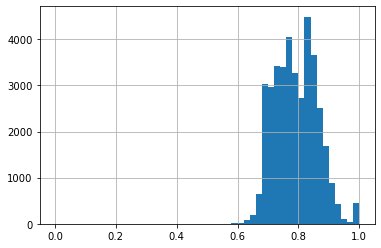

In [445]:
cp3['score1'].hist(bins=50)

In [455]:
cp3.loc[cp3['score1'] == 1].shape
cp3.loc[cp3['score1'].between(0.95, 0.99, inclusive='neither')].shape

(440, 10)

(64, 10)

In [457]:
# cp3.loc[cp3['score1'] == 1].sample(10)
# cp3.loc[cp3['score1'].between(0.95, 0.96)]  #.sample()
# cp3.loc[cp3['score1'].between(0.96, 0.97)]
cp3.loc[cp3['score1'].between(0.97, 0.98)]

,gvkey,conm,conml,namec,score1,m_namec1,score2,m_namec2,score3,m_namec3
151,1010,ACF INDUSTRIES INC,ACF Industries Inc,acf industries,0.976190,cf industries,0.837229,ace securities,0.767507,global industrial
26883,2224,BIOCHEM INTERNATIONAL INC,Biochem International Inc,biochem international,0.977778,biohemp international,0.862205,ensco international,0.850420,barrick international
153067,7978,NORTHERN STATES POWER/WI,Northern States Power/WI,northern states power/wi,0.975000,northern states power,0.912745,northern states power of minnesota,0.863278,northern trust
243148,12439,GENERAL ELECTRIC CAPITAL SVC,General Electric Capital Svc,general electric capital svc,0.971429,general electric capital,0.914286,general electric,0.834127,general motors financial
322158,20265,CS RESOURCES LTD,CS Resources Ltd,cs resources,0.979487,csn resources,0.815873,gulf resources,0.779582,skye resources
326642,20838,UTS ENERGY CORP,UTS Energy Corp,uts energy,0.970000,us energy,0.896296,txu energy,0.809259,puget energy
368752,27240,BALLYS CORP,Ballys Corp,ballys,0.971429,ballys,0.775000,bway,0.772222,barclays capital
416608,37445,AARONS CO INC (THE),Aarons Co Inc (The),aarons,0.971429,aaron s,0.800000,adaro indonesia pt,0.750000,mars
461720,100401,SPIRENT COMMUNICATIONS,Spirent Communications,spirent communications,0.975180,sprint communications,0.838915,cricket communications,0.776431,iheartcommunications
465258,106092,INVESTCO INC,Investco Inc,investco,0.975000,invesco,0.813492,vimetco,0.813333,ineos


In [424]:
df2.loc[df2['namec'] == 'lg e ku energy']

,RepRisk_ID,name,namec
580944,62219,LG&E and KU Energy LLC (formerly E.ON US),lg e ku energy
